# Ensemble: simass

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'SImon'
experiment = 'ssp585'
variable_id = 'simass'

spatial_text = 'sea-ice mass'
spatial_units = 'kg m⁻²'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = 'Gt'
time_series_y_label = f'Mass ({time_series_units})'
time_series_y_range = (0, 3.75e7)
time_series_y_range_full = (0, 4.25e7)
time_series_y_range_monthly = (0, 4e7)
time_series_y_range_regional = (0, 1.6e7)

# Convert from kg to Gt
time_series_process = lambda x: x * 1e-9

colormesh_kwargs = {
    'extend': 'max',
    'levels': 21,
    #'shading': 'auto', # NB change to 'gouraud' if Jaspy
    'vmin': 0,
    'vmax': 3000,
    'x': 'longitude', 
    'y': 'latitude'
}

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id
)

ensemble_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)
ensemble_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment, suffix='_smooth')
)

time_slices = libs.vars.default_time_slices()
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

## Time series

### Mean

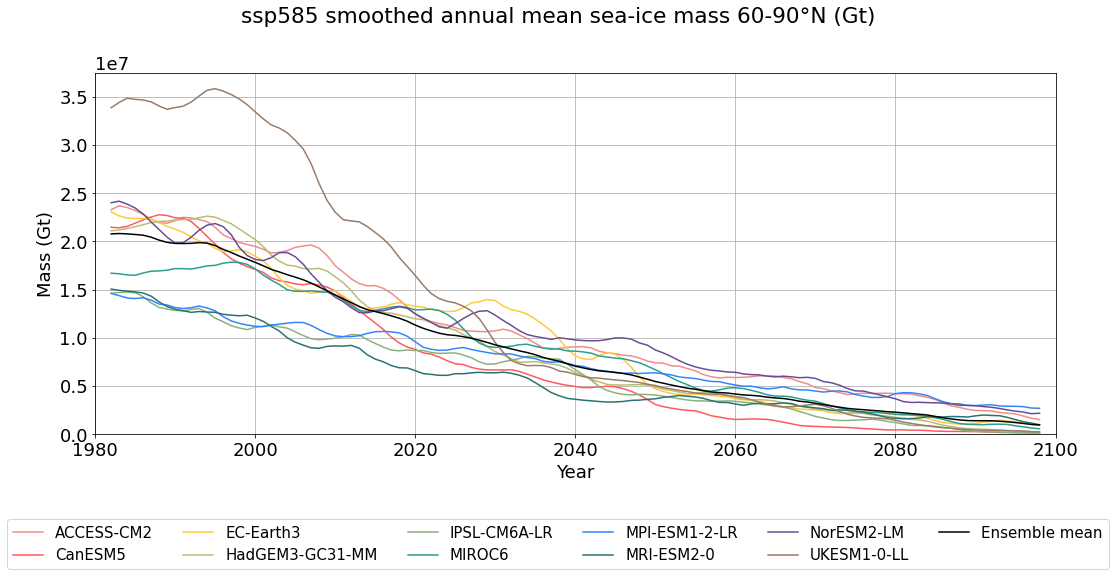

In [4]:
# libs.plot.time_series_from_vars(
#     ensemble_time_series_smooth,
#     title=f'{experiment} smoothed monthly {time_series_text} 60-90°N ({time_series_units})',
#     xattr='time',
#     ylabel=time_series_y_label,
#     yrange=time_series_y_range
# );

vars_series = [
    ensemble_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)


libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} smoothed annual mean {time_series_text} 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);
# High UKESM1-0-LL could be due to sea ice too thick (Sellar et al., 2019)

### September (min) & March (max)

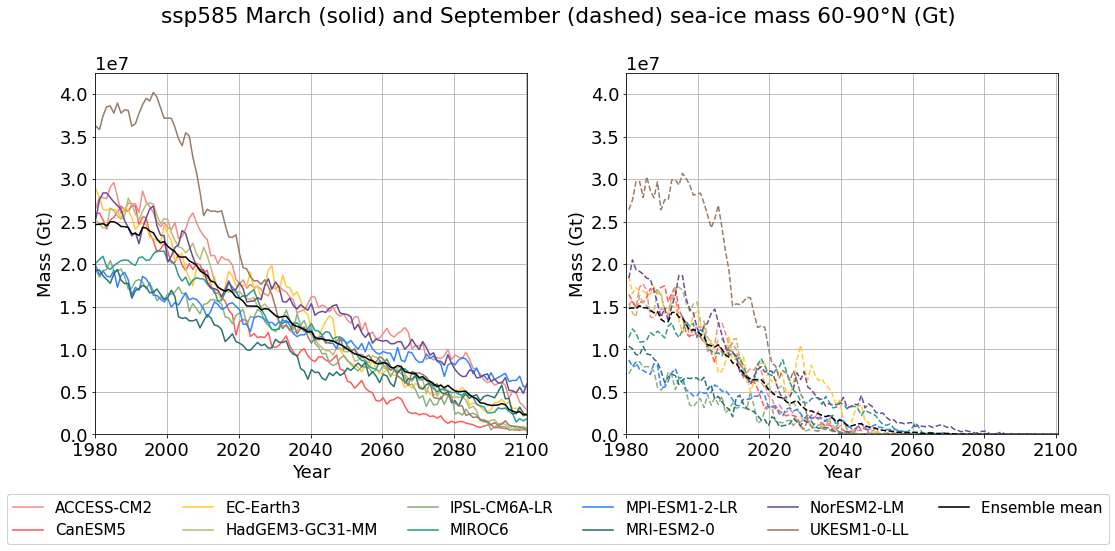

In [5]:
data_vars_mar = {}
data_vars_sep = {}

for i, item in enumerate(ensemble):
    processed_data = time_series_process(item['data'])
    processed_data.attrs['color'] = item['color']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    
    item_weighted_mar = processed_data.where(processed_data.time['time.month'] == 3, drop=True).weighted(weight)
    item_reduced_mar = getattr(
        item_weighted_mar, 
        time_series_weighted_method
    )(dim=item_weighted_mar.weights.dims, skipna=True)
    
    item_weighted_sep = processed_data.where(processed_data.time['time.month'] == 9, drop=True).weighted(weight)
    item_reduced_sep = getattr(
        item_weighted_sep, 
        time_series_weighted_method
    )(dim=item_weighted_sep.weights.dims, skipna=True)
    item_reduced_sep.attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    
    data_vars_mar[item['label']] = item_reduced_mar
    data_vars_sep[item['label']] = item_reduced_sep

ds_mar = xarray.Dataset(data_vars=data_vars_mar)
ds_mar = libs.ensemble.calc_variable_mean(ds_mar)

ds_sep = xarray.Dataset(data_vars=data_vars_sep)
ds_sep = libs.ensemble.calc_variable_mean(ds_sep)
ds_sep['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle(f'{experiment} March (solid) and September (dashed) {time_series_text} 60-90°N ({time_series_units})')

libs.plot.time_series_from_vars(
    [
        ds_mar
    ],
    #cols=6,
    ax=axes[0],
    fig=fig,
    xattr='time',
    ylabel=time_series_y_label,
    yrange=time_series_y_range_full
);
libs.plot.time_series_from_vars(
    [
        ds_sep
    ],
    #cols=6,
    ax=axes[1],
    fig=fig,
    xattr='time',
    ylabel=time_series_y_label,
    yrange=time_series_y_range_full
);

### Full variability

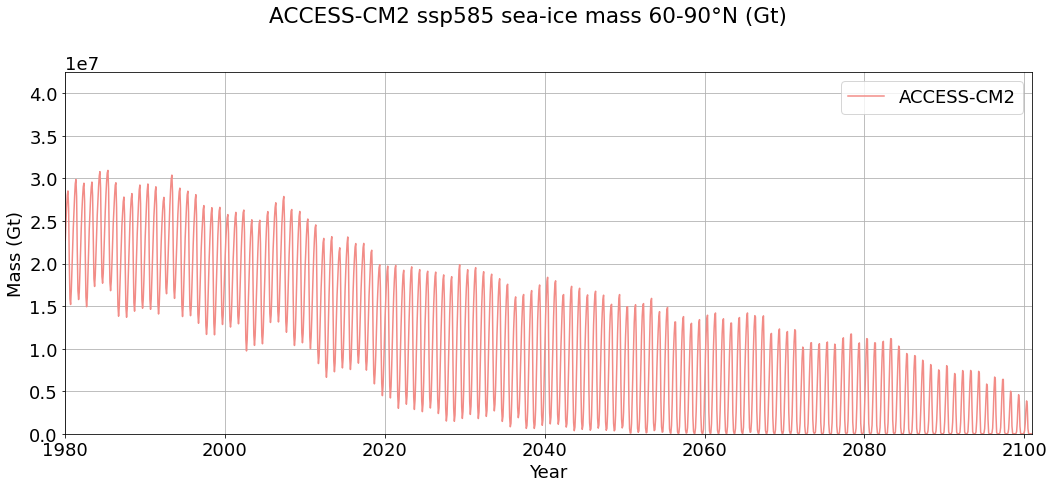

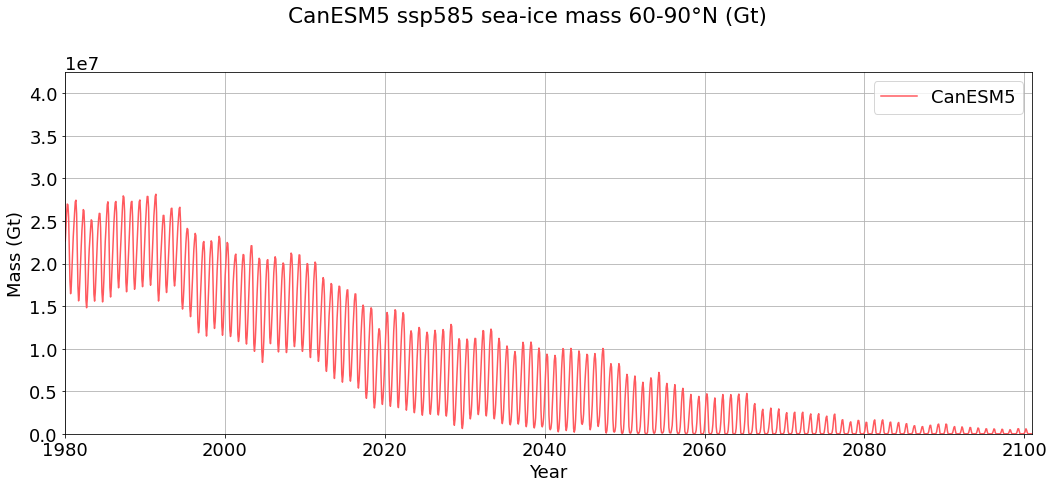

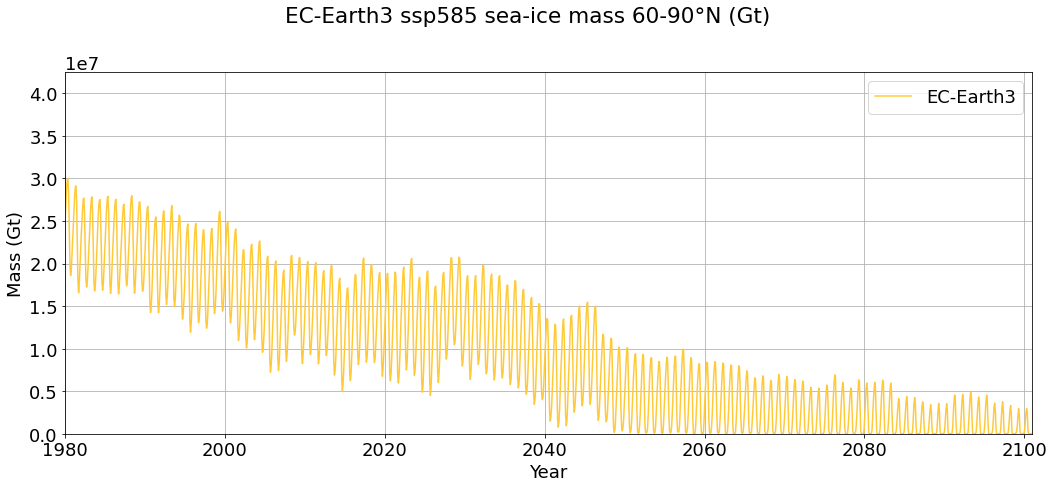

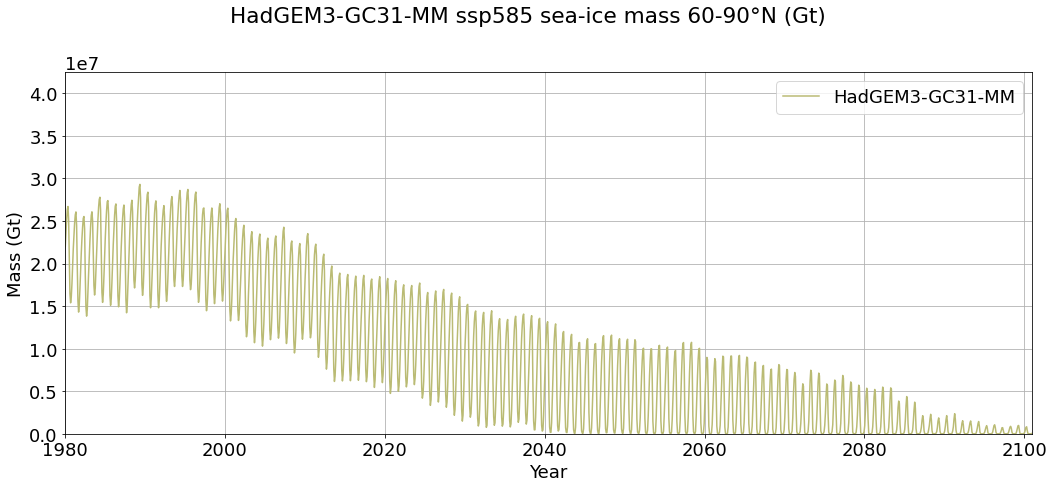

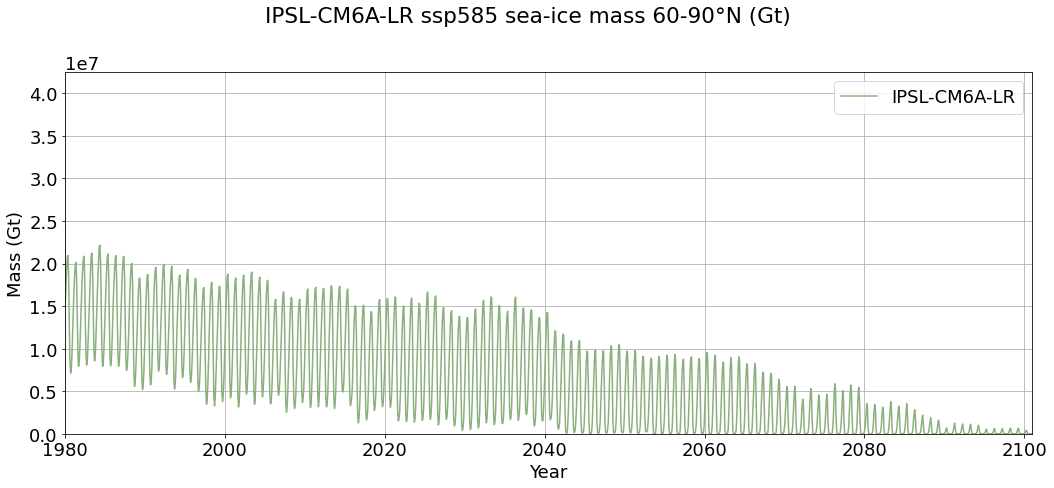

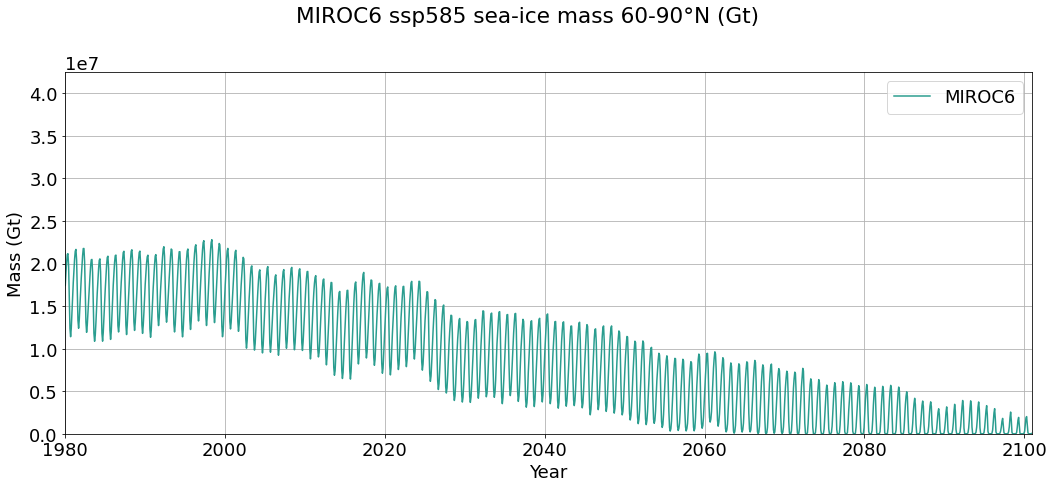

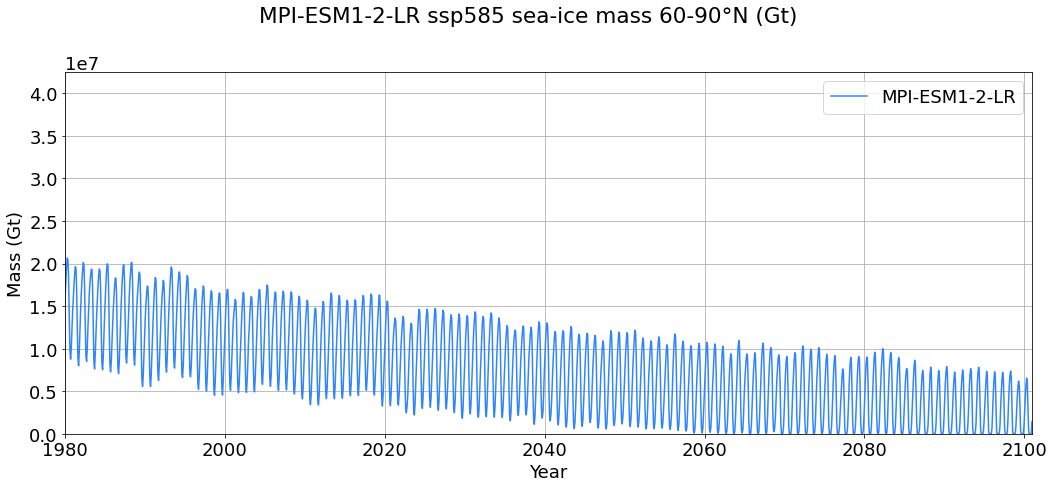

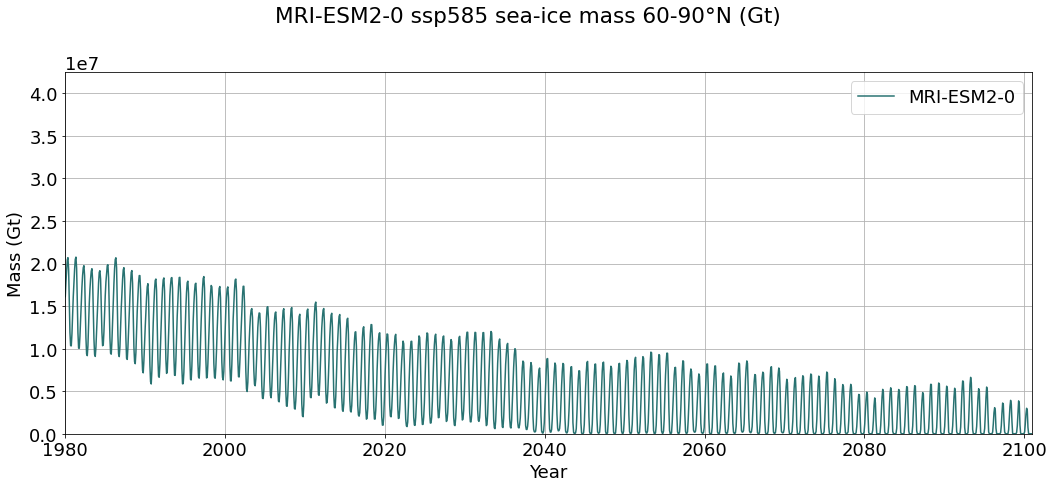

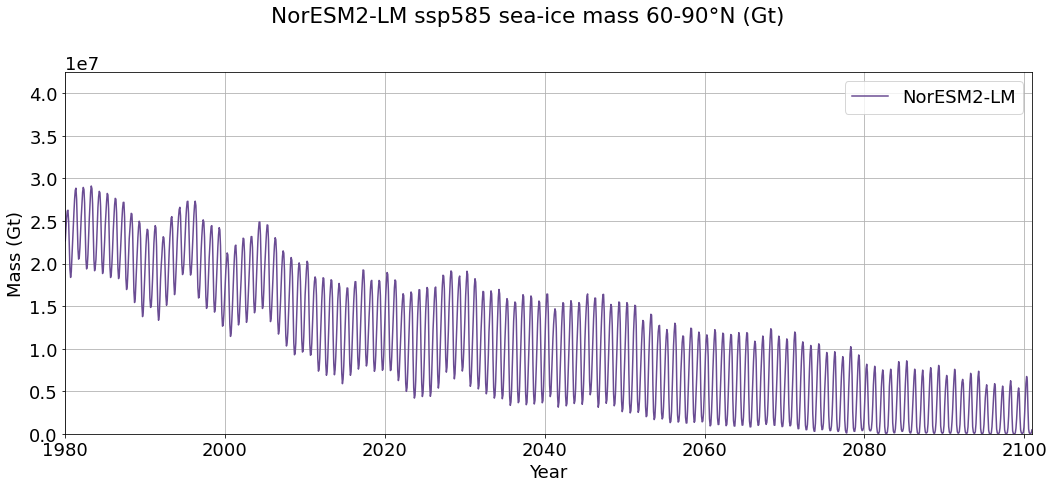

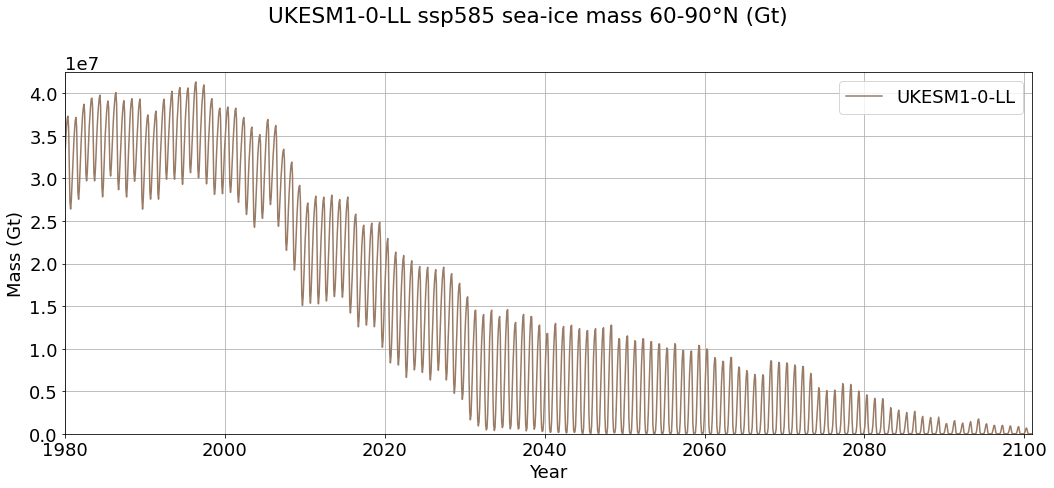

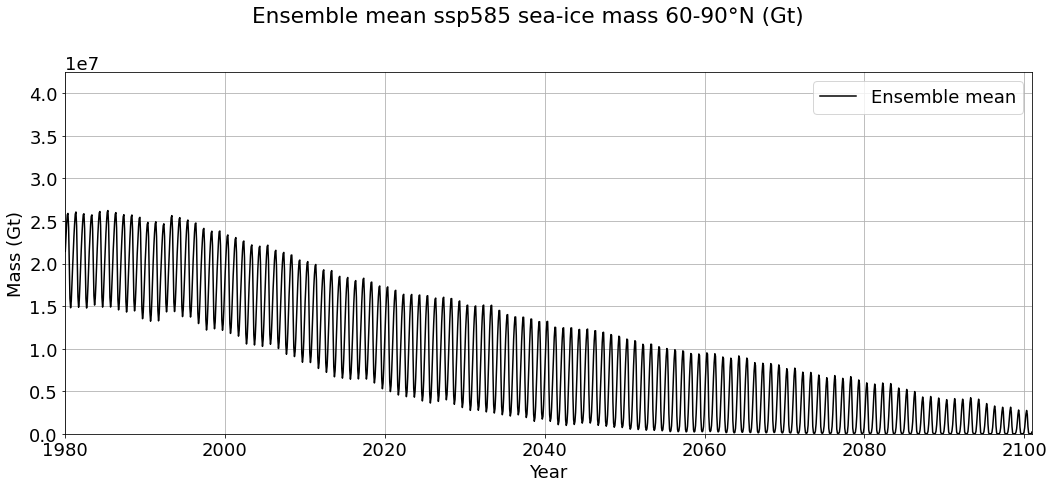

In [6]:
libs.ensemble.time_series_full_variability(
    ensemble_time_series,
    plot_kwargs={
        'title': f'{{member}} {experiment} {time_series_text} 60-90°N ({time_series_units})',
        'ylabel': time_series_y_label,
        'yrange': time_series_y_range_full
    }
)

## Monthly variability

### Full region (time)

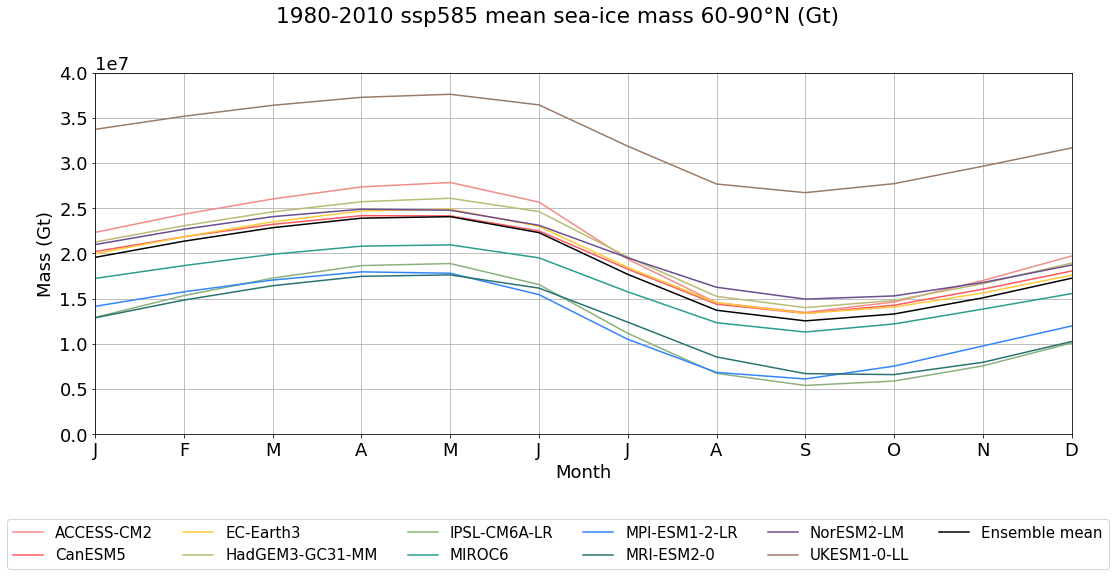

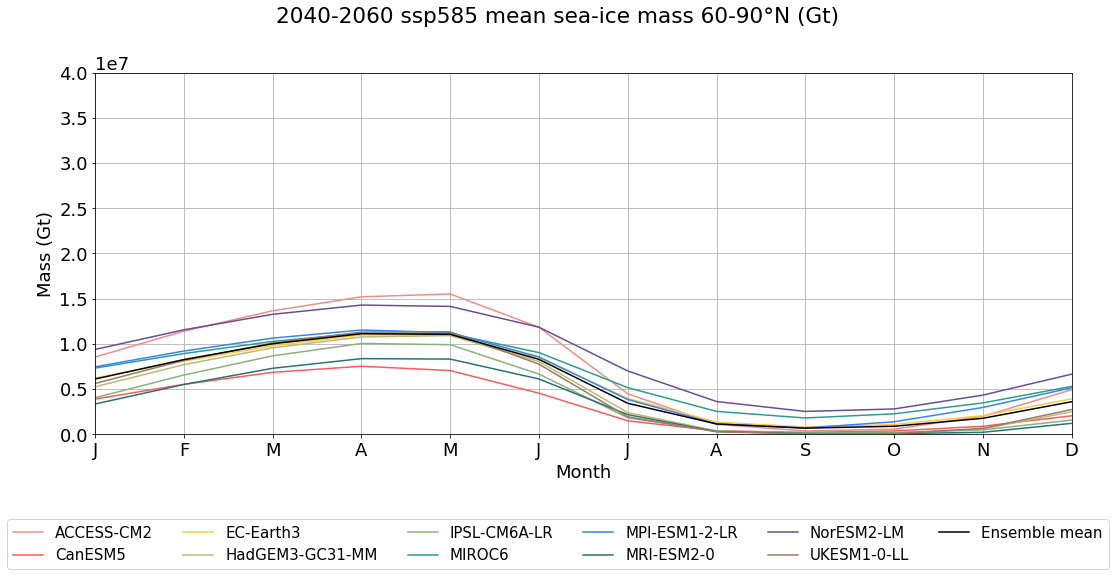

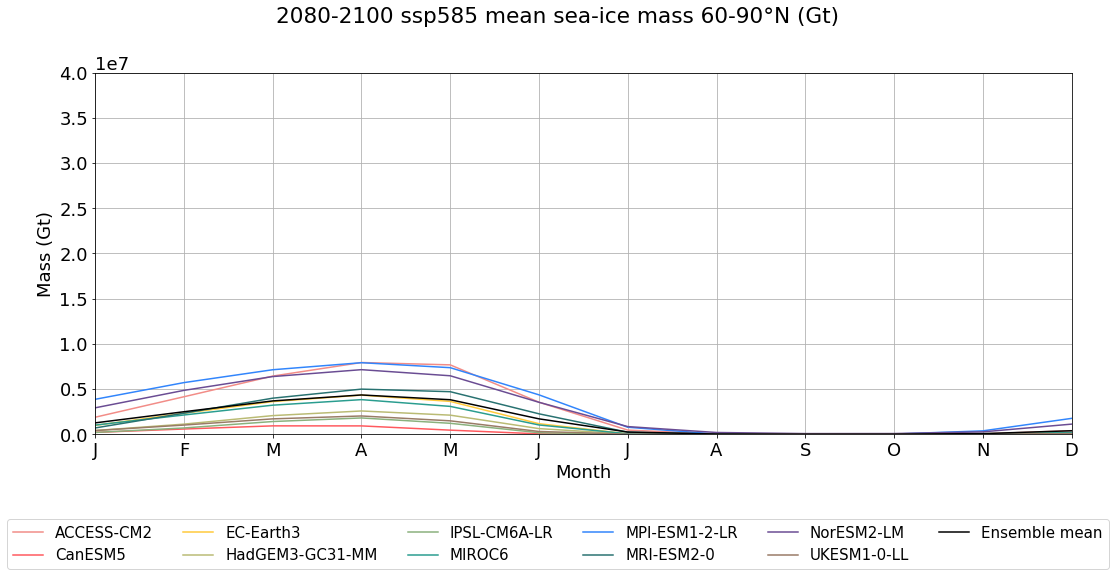

In [7]:
for s in time_slices:
    s_label = s['label']

    libs.plot.monthly_variability(
        ensemble_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_monthly
    )

### Regional (time)

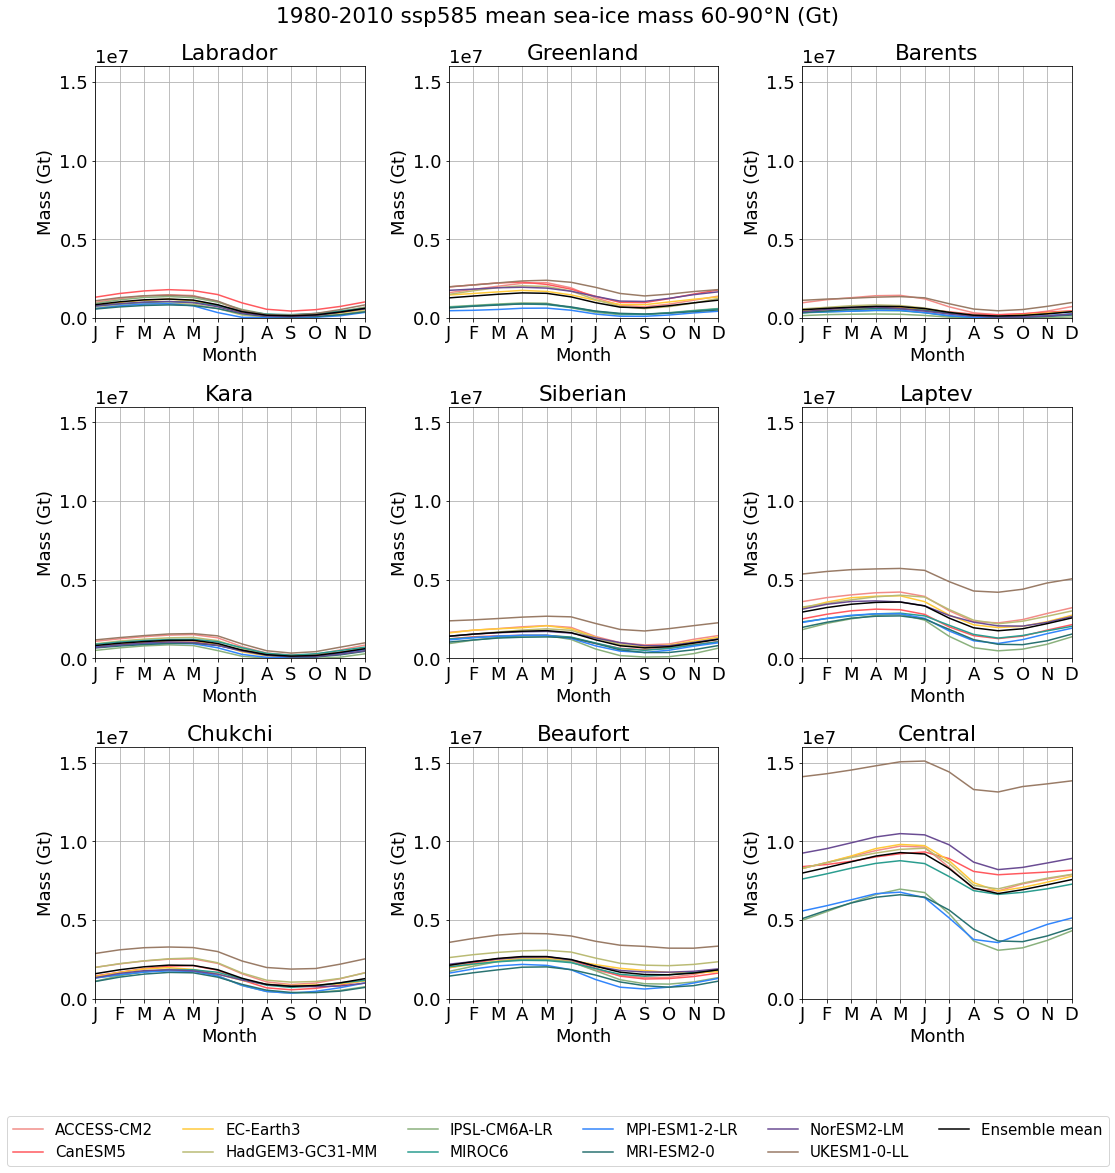

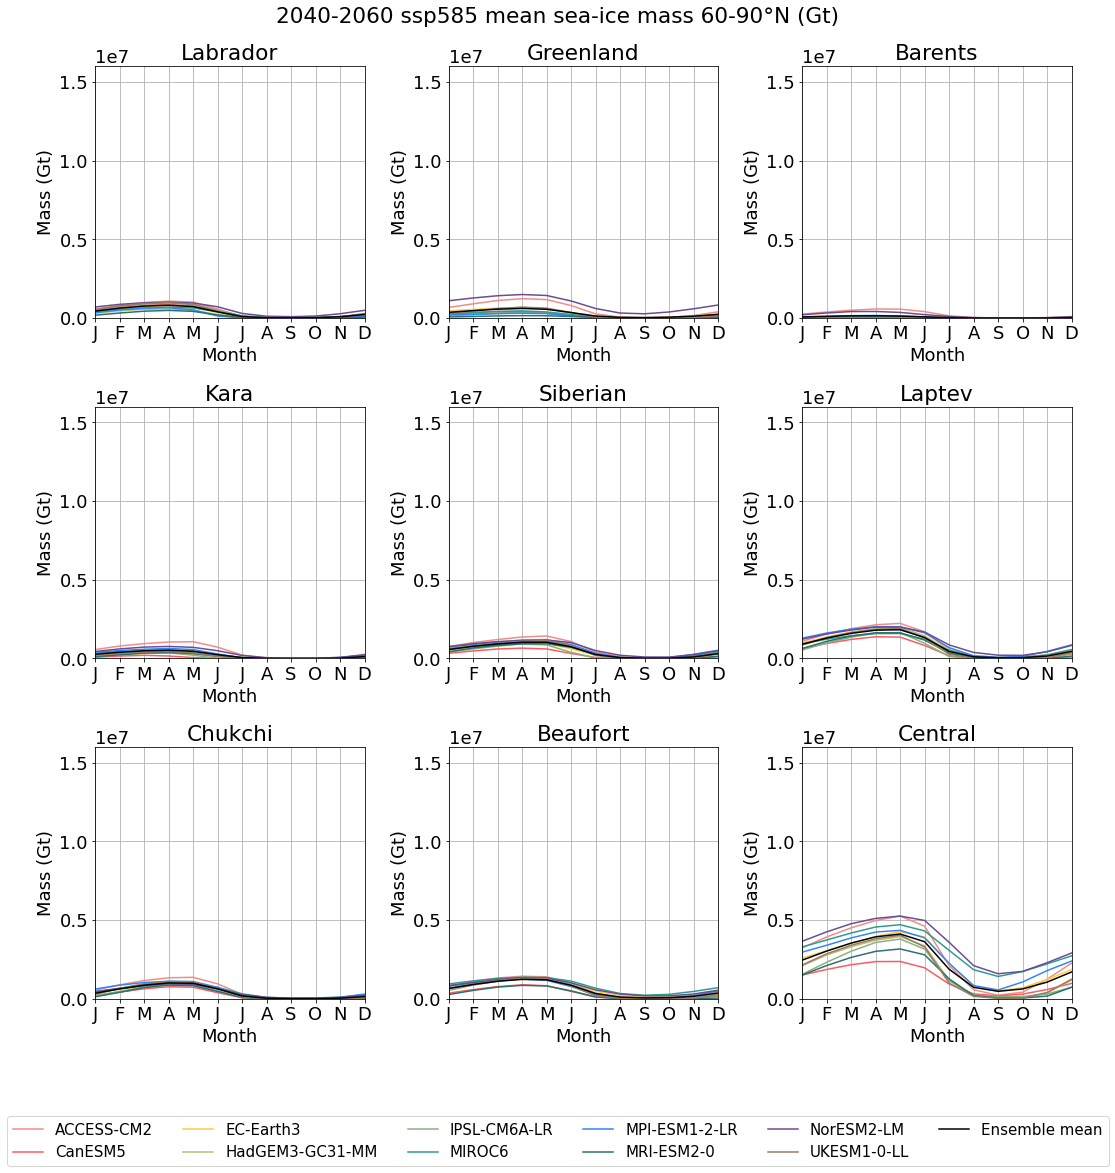

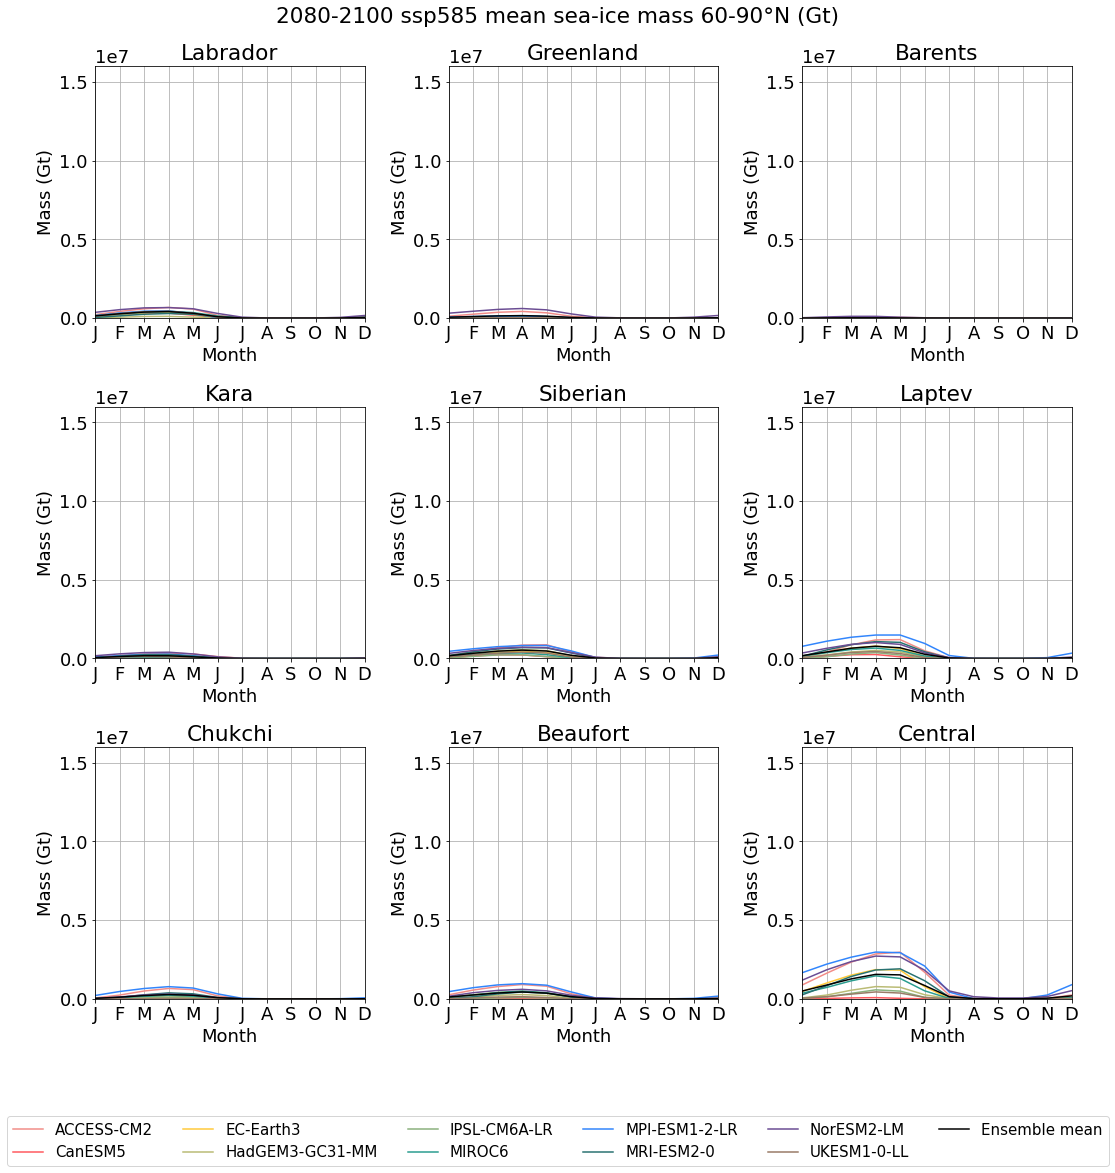

In [8]:
regions = libs.local.get_ensemble_regional_series(variable_id, experiment)

for s in time_slices:
    s_label = s['label']
    regional_time_slices = [
        time_series_process(
            data.sel(**s['slice']).groupby('time.month').mean('time')
        ) for data in regions
    ]

    libs.plot.monthly_variability_regional(
        regional_time_slices,
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_regional
    )

### Full region March maximum (spatial)

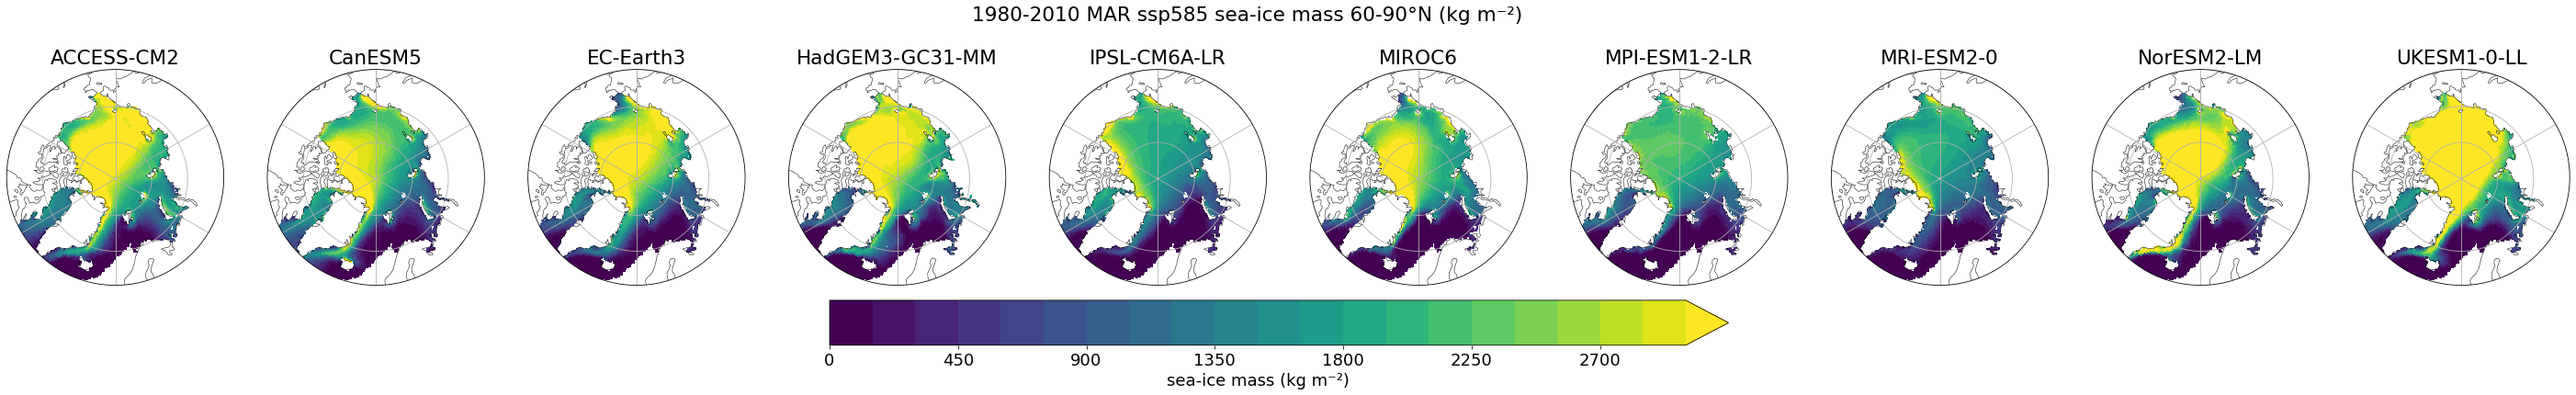

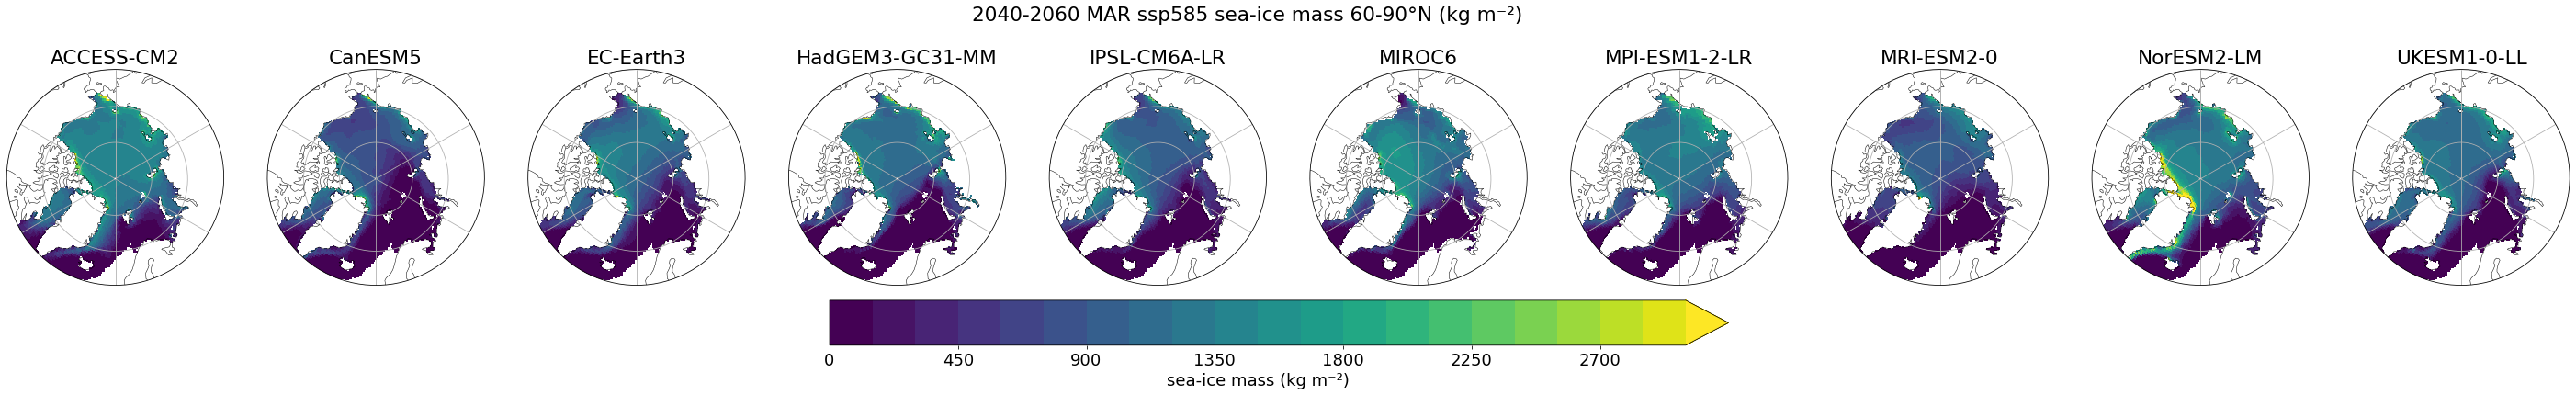

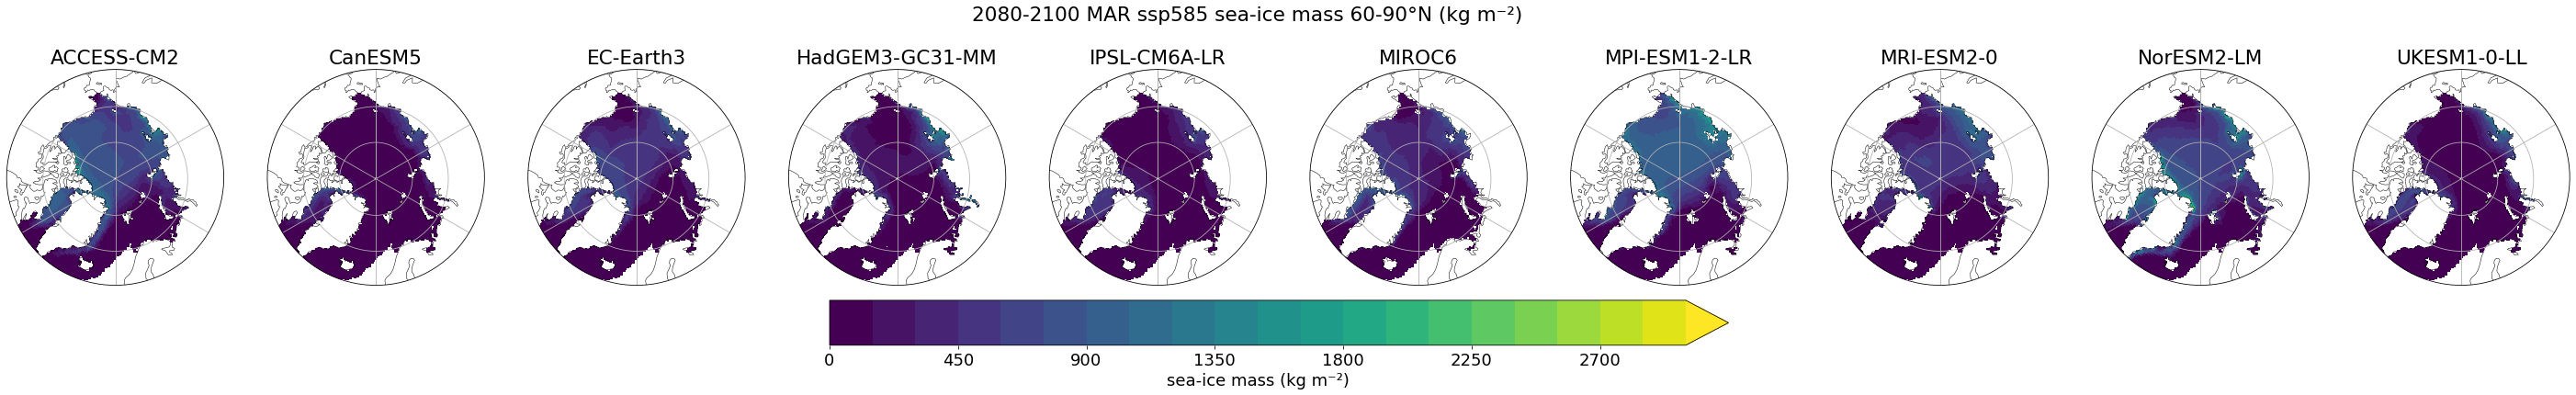

In [9]:
import warnings
warnings.filterwarnings('ignore')

libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='MAR',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)

### Full region September minimum (spatial)

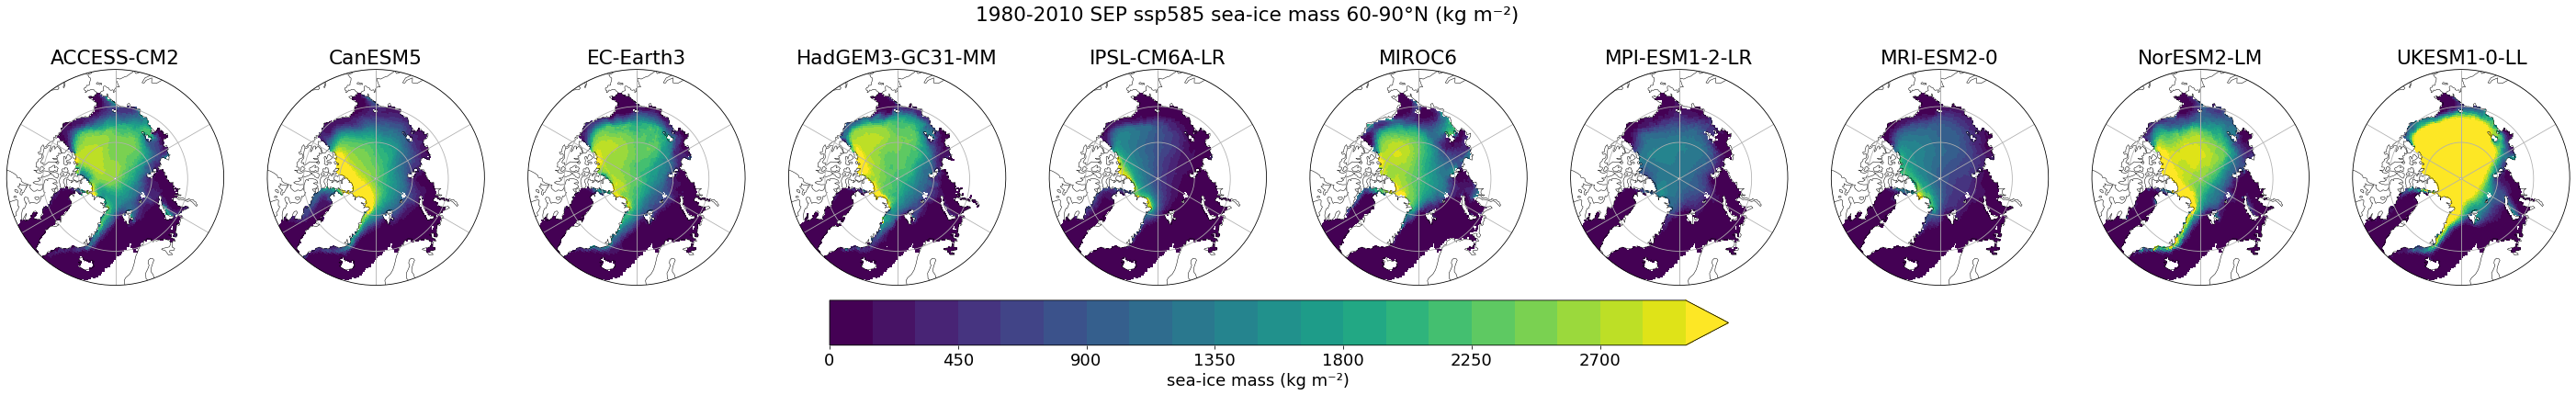

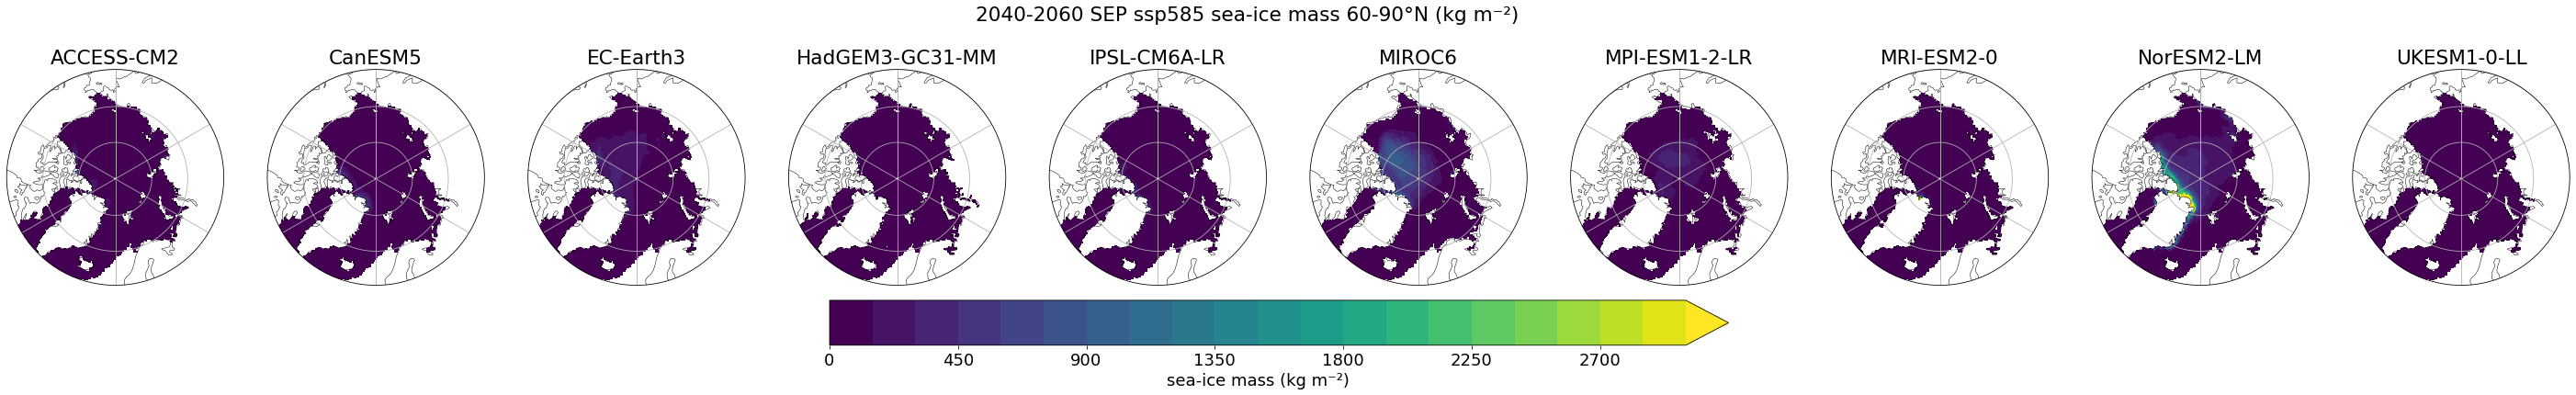

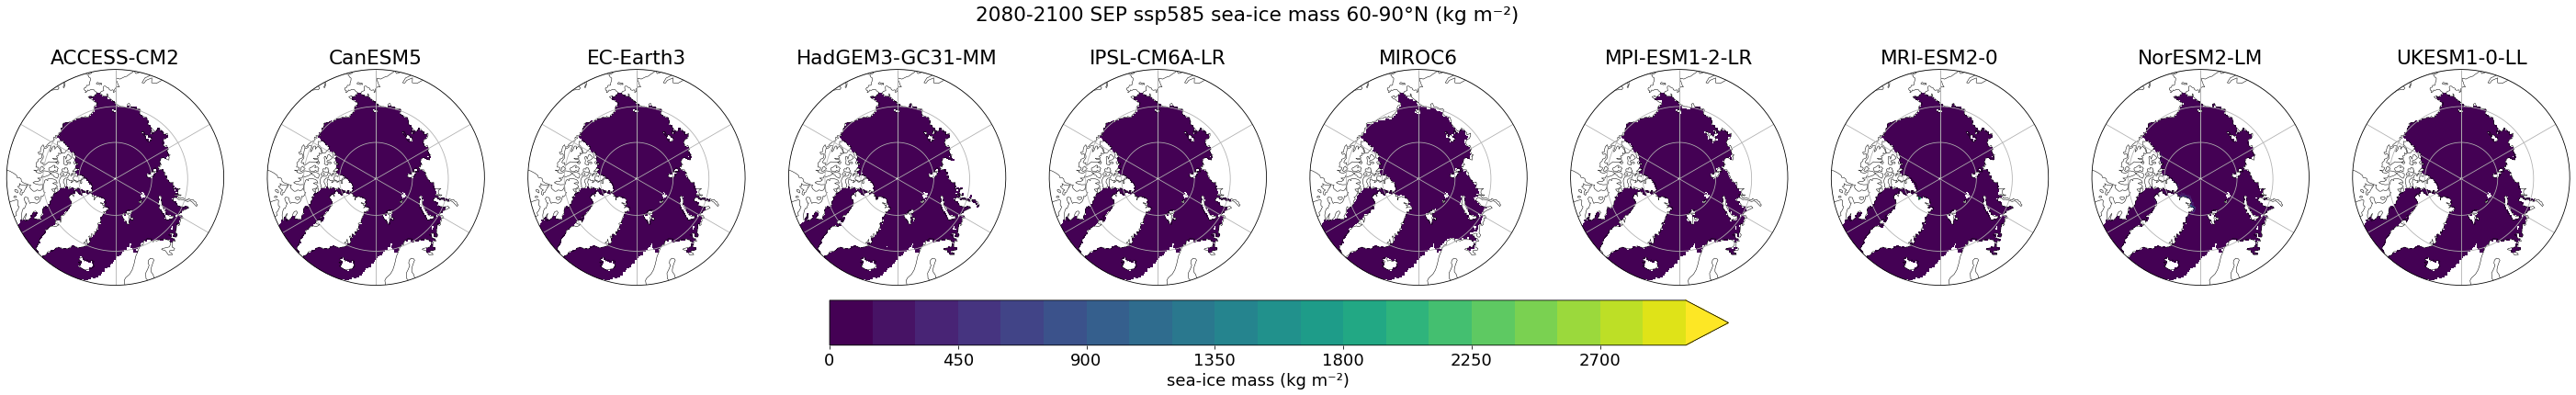

In [10]:
libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='SEP',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)